# Installation

In [ ]:
import numpy as np
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import scipy
from scipy.optimize import minimize, curve_fit

import pandas as pd

In [ ]:
#=============================================================================================
# General robust competitive binding model
#=============================================================================================

class GeneralBindingModel:
   """
   General robust binding model for one protein and arbitrary number of competitive ligands.

   """

   @classmethod
   def equilibrium_concentrations(cls, reactions, conservation_equations, tol=1.0e-8, initial_guess='zero'):
      """
      Compute the equilibrium concentrations of each complex species for a general set of binding reactions.

      Parameters
      ----------
      reactions : list
          List of binding reactions.
          Each binding reaction is encoded as a tuple of (log equilibrium constant, dict of stoichiometry)
          Example: K_d = [RL] / ([R] [L]) becomes [ (-10, {'RL': -1, 'R' : +1, 'L' : +1}) ]
      conservation_equations : list
          List of mass conservation laws.
          Each mass conservation law is encoded as a tuple of (log total concentration, dict of stoichiometry of all species)
          Example: [R]tot = 10^-6 M = [RL] + [R] and [L]tot = 10^-6 M = [RL] + [L] becomes [ (-6, {'RL' : +1, 'R' : +1}), (-6, {'RL' : +1, 'L' : +1}) ]
      tol : float, optional, default=1.0e-8
          Solution tolerance for log concentrations.
      initial_guess : str, optional, default='zero'
          If 'zero', will assume all initial log concentrations are zero.
          If 'spread', will spread out concentration among all species.

      Returns
      -------
      log_concs : dict of str : float
          log_concs[species] is the log concentration of specified species

      Examples
      --------

      Simple 1:1 association

      >>> reactions = [ (-10, {'RL': -1, 'R' : +1, 'L' : +1}) ]
      >>> conservation_equations = [ (-6, {'RL' : +1, 'R' : +1}), (-6, {'RL' : +1, 'L' : +1}) ]
      >>> log_concs = GeneralBindingModel.equilibrium_concentrations(reactions, conservation_equations)

     Competitive 1:1 association

      >>> reactions = [ (-10, {'RL': -1, 'R' : +1, 'L' : +1}), (-5, {'RP' : -1, 'R' : +1, 'P' : +1}) ]
      >>> conservation_equations = [ (-6, {'RL' : +1, 'RP' : +1, 'R' : +1}), (-6, {'RL' : +1, 'L' : +1}), (-5, {'RP' : +1, 'P' : +1}) ]
      >>> log_concs = GeneralBindingModel.equilibrium_concentrations(reactions, conservation_equations)

      TODO
      ----
      * Can we allow the caller to specify initial conditions instead of conservation laws?

      """

      nreactions = len(reactions)
      nconservation = len(conservation_equations)
      nequations = nreactions + nconservation

      # Determine names of all species.
      all_species = dict() # ordered
      for (log_equilibrium_constant, reaction) in reactions:
          for species in reaction.keys():
              all_species[species] = 1
      all_species = tuple(all_species.keys()) # order is now fixed
      nspecies = len(all_species)

      # Construct function with appropriate roots.
      def ftarget(X):
          target = np.zeros([nequations], np.float64)
          jacobian = np.zeros([nequations, nspecies], np.float64)
          equation_index = 0
          # Reactions
          for (log_equilibrium_constant, reaction) in reactions:
              target[equation_index] = - log_equilibrium_constant
              for (species_index, species) in enumerate(all_species):
                  if species in reaction:
                      stoichiometry = reaction[species]
                      target[equation_index] += stoichiometry * X[species_index]
                      jacobian[equation_index][species_index] = stoichiometry
              equation_index += 1
          # Conservation of mass
          from scipy.special import logsumexp
          for (log_total_concentration, conservation_equation) in conservation_equations:
              target[equation_index] = - log_total_concentration
              log_concs = list()
              for (species_index, species) in enumerate(all_species):
                  if species in conservation_equation:
                      stoichiometry = conservation_equation[species]
                      log_concs.append(X[species_index] + np.log(stoichiometry))
              log_concs = np.array(log_concs)
              logsum = logsumexp(log_concs)
              target[equation_index] += logsum
              for (species_index, species) in enumerate(all_species):
                  log_concs = list()
                  if species in conservation_equation:
                      stoichiometry = conservation_equation[species]
                      jacobian[equation_index, species_index] = stoichiometry * np.exp(X[species_index] - logsum)
              equation_index += 1

          return (target, jacobian)

      # Construct initial guess
      if initial_guess == 'spread':
          # We assume that all matter is equally spread out among all species via the conservation equations
          from scipy.misc import logsumexp
          LOG_ZERO = -100
          X = LOG_ZERO * np.ones([nspecies], np.float64)
          for (species_index, species) in enumerate(all_species):
              for (log_total_concentration, conservation_equation) in conservation_equations:
                  log_total_stoichiometry = np.log(np.sum([stoichiometry for stoichiometry in conservation_equation.values()]))
                  if species in conservation_equation:
                      stoichiometry = conservation_equation[species]
                      #X[species_index] = logsumexp([X[species_index], log_total_concentration + np.log(stoichiometry) - log_total_stoichiometry])
                      X[species_index] = np.logaddexp(X[species_index], log_total_concentration + np.log(stoichiometry) - log_total_stoichiometry)
      elif initial_guess == 'zero':
          # Simple guess: All log concentrations are zero
          X = np.zeros([nspecies], np.float64)
      else:
          raise ValueError('Unknown initial_guess {}'.format(initial_guess))

      # Solve
      from scipy.optimize import root
      options = {'xtol' : tol}
      sol = root(ftarget, X, method='lm', jac=True, tol=tol, options=options)
      if (sol.success == False):
          msg  = "root-finder failed to converge:\n"
          msg += str(sol)
          raise Exception(msg)

      # TODO: Ensure all constraints and conservation equations are satisfied?

      log_concs = { all_species[index] : sol.x[index] for index in range(nspecies) }

      return log_concs #, sol['cov_x']

# Functions

## Kinetics

In [ ]:
def DimerBindingModel(logMtot, logStot, logItot,
                      logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI):
    """
    Compute equilibrium concentrations for a binding model in which a ligand and substrate 
    competitively binds to a monomer, dimer, or dimer complexed with a ligand.
    
    Parameters
    ----------
    logMtot : numpy array
      Log of the total protein concentation summed over bound and unbound species
    logStot : numpy array
      Log of the total substrate concentation summed over bound and unbound species
    logItot : numpy array
      Log of the total ligand concentation summed over bound and unbound species
    """
    species = ['M','D','I','S','MS','MI','DI','DI2','DS','DSI','DSS']
    # relationships between dissociation constants due to loops 
    logKd_MS_M = logKd + logK_S_D - logK_S_M
    logKd_MI_M = logKd + logK_I_D - logK_I_M
    logK_I_DS = logK_I_D + logK_S_DI - logK_S_D

    reactions = [(logKd, {'M':2, 'D':-1}),               # Dimerization
                 (logKd_MS_M, {'MS':1, 'M':1, 'DS': -1}),
                 (logK_S_M, {'M': 1, 'S':1, 'MS': -1}),  # Substrate binding
                 (logK_S_D, {'D':1, 'S':1, 'DS': -1}),                 
                 (logK_S_DS, {'DS':1, 'S':1, 'DSS':-1}),
                 (logKd_MI_M, {'MI':1, 'M':1, 'DI': -1}),
                 (logK_I_M, {'M':1, 'I':1, 'MI': -1}),   # Inhibitor binding
                 (logK_I_D, {'D':1, 'I':1, 'DI':-1}),                
                 (logK_I_DI, {'DI':1, 'I':1, 'DI2':-1}),             
                 (logK_I_DS, {'DS':1, 'I':1, 'DSI':-1}), # Substrate and inhibitor binding                  
                 (logK_S_DI, {'DI':1, 'S':1, 'DSI':-1})
                 ]
    log_concs = dict([(key, np.zeros(logItot.shape[0])) for key in species])

    for n in range(logItot.shape[0]):
        conservation_equations = [(logMtot[n], {'M':+1,'D':+2,'MS':+1,'MI':+1,'DI':+2,'DI2':+2,'DS':+2,'DSI': +2,'DSS':+2}), # Total protein
                                  (logItot[n], {'I':+1, 'MI':+1, 'DI':+1, 'DI2':+2, 'DSI':+1}),                              # Total ligand
                                  (logStot[n], {'S':+1, 'MS':+1, 'DS':+1, 'DSI':+1, 'DSS':+2})                               # Total substrate
                                  ]
        log_c = GeneralBindingModel.equilibrium_concentrations(reactions, conservation_equations)
        for key in species:
            log_concs[key][n] = log_c[key]
    
    return log_concs


def ReactionRate(logMtot, logStot, logItot,
                 logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                 kcat_MS=0., kcat_DS=0., kcat_DSI=1., kcat_DSS=1.):
    """
    Reaction Rate
      v = kcat_MS*[MS] + kcat_+DS*[DS] + kcat_DSI*[DSI] + kcat_DSS*[DSS]
    
    Parameters
    ----------
    logMtot : numpy array
      Log of the total protein concentation summed over bound and unbound species
    logStot : numpy array
      Log of the total substrate concentation summed over bound and unbound species
    logItot : numpy array
      Log of the total ligand concentation summed over bound and unbound species      
    """

    log_concs = DimerBindingModel(logMtot, logStot, logItot,
                                  logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI)
    v = kcat_MS*np.exp(log_concs['MS']) + kcat_DS*np.exp(log_concs['DS']) + kcat_DSI*np.exp(log_concs['DSI']) + kcat_DSS*np.exp(log_concs['DSS'])
    return v

def MonomerConcentration(logMtot, logStot, logItot, 
                         logKd, logK_S_M, logK_S_D, logK_S_DS, 
                         logK_I_M, logK_I_D, logK_I_DI, logK_S_DI):
    """
    Response of DimerBindingModel
      Response ~ v = kcat_MS*[MS] + kcat_+DS*[DS] + kcat_DSI*[DSI] + kcat_DSS*[DSS]
    
    Parameters
    ----------
    logMtot : numpy array
      Log of the total protein concentation summed over bound and unbound species
    logStot : numpy array
      Log of the total substrate concentation summed over bound and unbound species
    logItot : numpy array
      Log of the total ligand concentation summed over bound and unbound species      
    """
    log_concs = DimerBindingModel(logMtot, logStot, logItot,
                                  logKd, logK_S_M, logK_S_D, logK_S_DS, 
                                  logK_I_M, logK_I_D, logK_I_DI, logK_S_DI)
    return np.sum(np.exp([log_concs[species] for species in ['M','MI','MS']]),0)

In [ ]:
def CatalyticEfficiency(logMtot, logItot,
                        logKd, logK_S_M, logK_S_D, logK_S_DS,
                        logK_I_M, logK_I_D, logK_I_DI, logK_S_DI, 
                        kcat_MS=0., kcat_DS=0., kcat_DSI=1., kcat_DSS=1.,
                        logStot = None):
    """
    kcat/Km, based on the finite difference derivative
    
    Parameters
    ----------
    logMtot : numpy array
      Log of the total protein concentation summed over bound and unbound species
    logItot : numpy array
      Log of the total ligand concentation summed over bound and unbound species      
    """
    if logStot is None:
        logStot = np.log(np.array([1, 2])*1E-6)
    DeltaS = (np.exp(logStot[1])-np.exp(logStot[0]))

    catalytic_efficiency = np.zeros(logItot.shape)
    for (logItot_ind, ind) in zip(logItot, range(logItot.shape[0])):
      v = ReactionRate(np.array([logMtot[ind], logMtot[ind]]), 
                       logStot, np.array([logItot_ind, logItot_ind]), 
                       logKd, logK_S_M, logK_S_D, logK_S_DS,
                       logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                       kcat_MS, kcat_DS, kcat_DSI, kcat_DSS)
      catalytic_efficiency[ind] = (v[-1]-v[0])/DeltaS
    return catalytic_efficiency

## CRC

In [ ]:
def f_curve_vec(x, R_b, R_t, x_50, H):
    """
    Dose-response curve function
    
    Parameters:
    ----------
    x   : array
          log_10 of concentration of inhibitor
    R_b : float
          bottom response
    R_t : float
          top response
    x_50: float
          logIC50
    H   : float
          hill slope
    ----------
    return an array of response
    """
    return R_b+(R_t-R_b)/(1+10**(x*H-x_50*H))


def parameter_estimation(data, theta=None, variances=None, itnmax=100, tol=1e-4): 
    """
    Fitting non-linear regression without control
    Parameters:
    ----------
    data      : list of two element: x, y, c1, c2.
                x is vector of concentration
                y is vector of responsex and y must be same length
    theta     : vector of 4 parameters (bottom response, top response, logIC50, hill slope)
    ----------
    return [theta, ASE, variance]
    """

    # Initial value and boundary for theta
    min_y = min(data['y'])
    max_y = max(data['y'])
    range_y = max_y - min_y

    if theta is None:
        theta = [min_y, max_y, data['x'][np.argmin(np.square(data['y']-np.mean(data['y'])))], 1.0]
        upper = [min_y + 0.25*range_y, max_y + 0.25*range_y, 20, 20]
        lower = [min_y - 0.25*range_y, max_y - 0.25*range_y, -20, -20]
    else:
        upper = [theta[0] + 0.25*range_y, theta[1] + 0.25*range_y, 20, 20]
        lower = [theta[0] - 0.25*range_y, theta[1] - 0.25*range_y, -20, -20]

    fit_f, var_matrix = curve_fit(f_curve_vec, xdata=np.array(data['x']), ydata=np.array(data['y']),
                                  absolute_sigma=True, p0=theta,
                                  bounds=(lower, upper))
    
    # Estimate ASE for theta
    y_hat = f_curve_vec(data['x'], *fit_f)
    sigma = np.sqrt(np.sum((y_hat - data['y'])**2)/(len(y_hat)-4))
    ASE = np.sqrt(np.diag(var_matrix))*sigma #unscale_SE*sigma

    mle = [fit_f, ASE, np.array([sigma**2])]

    return mle


def scaling_data(y, bottom, top):
    """
    This function is used to normalize data by mean of top and bottom control
    
    Parameters:
    ----------
    y     : vector of response
    bottom: mean of vector of control on the bottom
    top   : mean of vector of control on the top
    ----------

    return vector of normalized response 
    """
    min_y = min(bottom, top)
    max_y = max(bottom, top)
    return (y-min_y)/abs(max_y - min_y)*100

In [ ]:
def normalized_params(theta, ASE, bottom, top):
    """
    This function is used to normalize some parameters by mean of top and bottom control
    
    Parameters:
    ----------
    theta : vector of bottom response, top response, x50 and hill slope
    ASE   : vector of ASE of theta
    bottom: mean of vector of control on the bottom
    top   : mean of vector of control on the top
    ----------

    return vector of normalized theta and their ASE 
    """
    Rb = ufloat(theta[0], ASE[0])
    Rt = ufloat(theta[1], ASE[1])
    Rb_update = scaling_data(Rb, bottom, top)
    Rt_update = scaling_data(Rt, bottom, top)
    theta_update = np.array([Rb_update.n, Rt_update.n, theta[2], theta[3]])
    ASE_update = np.array([Rb_update.s, Rt_update.s, ASE[2], ASE[3]])
    return theta_update, ASE_update


def plot_crc_params(data, theta=None, positive=None, negative=None, outlier_pos=None, 
                    plot_control=True, data_normalizing=False, 
                    ax=None, line_color='b', line_style = '-', label_curve='Fitting',  
                    title_name=None, xlabel='$Log_{10}Concentration$', ylabel='Response', 
                    figure_size=(6.4, 4.8), dpi=80, outfile=None):
    """
    Parameters:
    ----------
    data            : list of experiment information: x, y, c1, c2, n_obs, outlier_pos.
                        x is vector of log10 of concentration
                        y is vector of response
                        c1 is control at bottom. c1 can be vector or None or 'None'
                        c2 is control at top. c2 can be vector or None or 'None'
                        n_obs is vector of nummber of replication at each concentration
                        outlier_pos is the position of outlier detected after first fitting
                        x and y must be same length
    theta           : vector, if no 'theta' in data, can using this plug-in theta
    positive        : vector, if no 'c1' in data, can using this plug-in positive control
    negative        : vector, if no 'c2' in data, can using this plug-in negative control
    outlier_pos     : vector, if no 'outlier_pos' in data, can using this plug-in outlier_pos
    plot_control    : boolean, if plot_control=False, no plotting the control despite of data has the control information
    data_normalizing: boolean, if negative and positive available, normalizing data
    ax              : if None, generating new plot
    line_color      : string, color of fitting line
    line_style      : string, line_style of fitting line
    label_curve     : string, label of fitting line
    title_name      : string, title of the plot
    xlabel, ylabel  : string, label of two axes of plot
    figure_size     : (width, height) size of plot
    dpi             : quality of plot
    outfile         : optional, string, output file for saving plot
    ----------
    return the plot of curve with information of params and their ASE
    """

    try: 
        y = data['y']
    except:
        y = data['response']

    try:
        x = data['x']
    except: 
        x = data['LogConcentration']

    if positive is None:
        if 'c1' in data.index or 'Positive' in data.index:
            try: 
                c1 = data['c1']
            except: 
                c1 = data['Positive']
        else:
            c1 = None
    else:
        c1 = positive

    if negative is None:
        if 'c2' in data.index or 'Negative' in data.index:
            try: 
                c2 = data['c2']
            except: 
                c2 = data['Negative']
        else:
            c2 = None
    else: 
        c2 = negative

    if theta is None: 
        if 'theta' in data.index and 'ASE' in data.index:
            theta = data['theta']
            ASE = data['ASE']
        else:
            print("Please provide the values for 4 parameters.")

    if data_normalizing: 
        if len(c1)>=0 and len(c2)>=0:
            y_update = scaling_data(y, np.mean(c1), np.mean(c2))
            c1_update = scaling_data(c1, np.mean(c1), np.mean(c2))
            c2_update = scaling_data(c2, np.mean(c1), np.mean(c2))
            theta_update, ASE_update = normalized_params(theta, ASE, np.mean(c1), np.mean(c2))

            y = y_update
            c1 = c1_update
            c2 = c2_update
            theta = theta_update
            ASE = ASE_update
        else: 
            print("Please provide negative/positive controls if you want to normalize data.")

    if ax is None:
        plt.figure(figsize=figure_size, dpi=dpi)
        ax = plt.axes()

    conc = np.linspace(min(x), max(x), num=50)
    fitted = f_curve_vec(conc, *theta)

    ax.plot(x, y, 'k.', label='Observed Data')
    ax.plot(conc, fitted, color=line_color, linestyle=line_style, label=label_curve)
    handles, labels = ax.get_legend_handles_labels()

    ax.text(0.65, 0.7,
            r'$R_b$: '+ str('%3.2f' %theta[0]) + ' $\pm$ ' + str('%3.2f' %ASE[0])
            + '\n$R_t$: '+ str('%3.2f' %theta[1]) + ' $\pm$ ' + str('%3.2f' %ASE[1]) 
            + '\n$x_{50}$: '+ str('%3.2f' %theta[2]) + ' $\pm$ ' + str('%3.2f' %ASE[2])
            + '\n$H$: ' + str('%3.2f' %theta[3]) + ' $\pm$ ' + str('%3.2f' %ASE[3]), 
        fontsize=11, transform=ax.transAxes, color='k')


    if plot_control and c1 !="None" and c1 is not None:
        ax.plot(np.repeat(max(x+0.5), len(c1)), c1, 'g^', label="$c_b$")
        handles, labels = ax.get_legend_handles_labels()
    
    if plot_control and c2 !="None" and c2 is not None:
        ax.plot(np.repeat(min(x-0.5), len(c2)), c2, 'gv', label="$c_t$")
        handles, labels = ax.get_legend_handles_labels()

    if outlier_pos is not None:
        ax.plot(x[outlier_pos], y[outlier_pos], 'rx')
        handles, labels = ax.get_legend_handles_labels()
    else: 
        if 'Outlier_Pos' in data.index and data['Outlier_Pos'] is not None and data['Outlier_Pos']!='None': 
            outlier_pos = data['Outlier_Pos']
            ax.plot(x[outlier_pos], y[outlier_pos], 'rx')
            handles, labels = ax.get_legend_handles_labels()

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title_name is not None:
        ax.set_title(title_name)

    # ax.legend(handles, labels, bbox_to_anchor=(1, 1))
    plt.tight_layout();
    
    if outfile is not None: 
        plt.savefig(outfile)
        plt.ioff()
    else:
        return ax

## Finding logItot

In [ ]:
def return_logItot(init_logMtot, init_logStot, kinetics_params, 
                   n_concs = 12, min_conc=1E-9, max_conc=1E3, min_percentage=1,
                   n_points = 50):
    """
    Parameters:
    ----------
    init_logMtot    : float, values of enzyme concentration in log scale
    init_logStot    : float, values of substrate concentration in log scale
    kinetics_params : list, including 8 logK and 4 kcat variables
    n_concs         : integer, number of concentrations for each scpecies
    min_concs       : float, minimal concentration for inhibitor
    max_concs       : float, maximal concentration for inhibitor
    min_percentage  : integer
        If you want inhibitor ranges from v_max to 0.1*v_max, then you set min_percentage=10
    ----------
    return array of concentrations for enzyme, substrate and inhibitor
    """
    [logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI, kcat_MS, kcat_DS, kcat_DSS, kcat_DSI] = kinetics_params
    # Generate the whole curve
    min_conc = np.log(min_conc)
    max_conc = np.log(max_conc)

    logMtot = np.ones(n_points)*init_logMtot 
    logStot = np.ones(n_points)*init_logStot 
    logItot = np.linspace(min_conc, max_conc, n_points)
    R = ReactionRate(logMtot, logStot, logItot,
                     logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                     kcat_MS, kcat_DS, kcat_DSS, kcat_DSI)
    
    # Find concentration of logItot that v = v_max
    index_max_R = np.argmax(R)
    conc_max_R = logItot[index_max_R]

    # scaling curve
    logItot_2 = np.linspace(logItot[index_max_R], max_conc, n_points)
    R_2 = ReactionRate(logMtot, logStot, logItot_2,
                       logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                       kcat_MS, kcat_DS, kcat_DSS, kcat_DSI)
    scaling_R = scaling_data(R_2, min(R_2), max(R_2))

    # Find concentration of logItot that v = 0.05 v_max
    for tol in [0.05, 0.1, 0.5, 1, 1.5, 2, 2.5, 3]:
        index_min_R = np.argmax(np.isclose(scaling_R, np.max(scaling_R)/100*min_percentage, rtol=tol))
        if index_min_R != 0:
            break
    conc_min_R = logItot_2[index_min_R]

    logItot_final = np.linspace(conc_max_R, conc_min_R, n_concs)
    logMtot_final = np.ones(n_concs)*init_logMtot 
    logStot_final = np.ones(n_concs)*init_logStot

    return logMtot_final, logStot_final, logItot_final

# Test

In [ ]:
logKd = -0.005 # Dimerization
# Substrate binding
logK_S_DS = -13.853
logK_S_M = -6.015
logK_S_D = -9.312
# Inhibitor binding
logK_I_M = 0
logK_I_D = -17.669
logK_I_DI = -18.141
# Binding of substrate and inhibitor
logK_S_DI = -13.967

kcat_MS = 0
kcat_DS = 0
kcat_DSI = 0.45
kcat_DSS = 0.38

In [ ]:
n_points = 50
n_concs = 12
min_conc = np.log(1E-9)
max_conc = np.log(1)
min_percentage=1

logMtot = np.array([np.log(10E-6)]*n_points) 
logStot = np.array([np.log(0.25E-3)]*n_points) 
logItot = np.linspace(min_conc, max_conc, n_points)

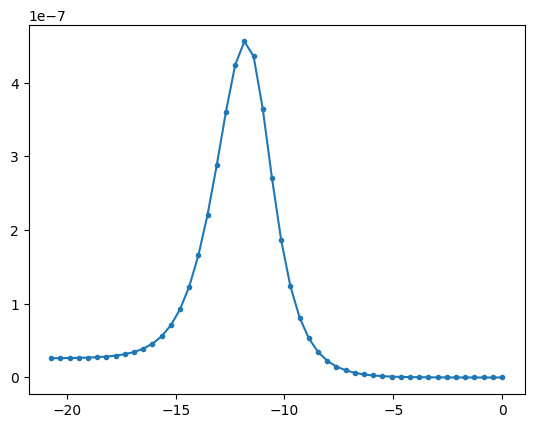

In [ ]:
R = ReactionRate(logMtot, logStot, logItot,
                 logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                 kcat_MS, kcat_DS, kcat_DSS, kcat_DSI)
plt.plot(logItot, R, ".-");

In [ ]:
index_max_R = np.argmax(R)
conc_max_R = logItot[index_max_R]

logItot = np.linspace(logItot[index_max_R], max_conc, n_points)
R = ReactionRate(logMtot, logStot, logItot,
                 logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                 kcat_MS, kcat_DS, kcat_DSS, kcat_DSI)

In [ ]:
scaling_R = scaling_data(R, min(R), max(R))
index_min_R = np.argmax(np.isclose(scaling_R, np.max(scaling_R)/100*min_percentage, rtol=1e-1))
conc_min_R = logItot[index_min_R]
logItot_2 = np.linspace(conc_max_R, conc_min_R, n_concs)

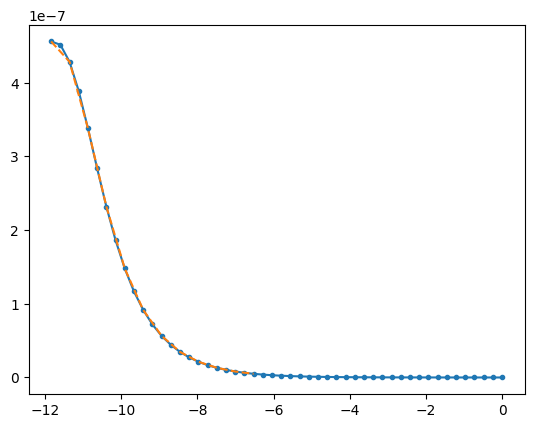

In [ ]:
R_2 = ReactionRate(logMtot, logStot, logItot_2,
                   logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                   kcat_MS, kcat_DS, kcat_DSS, kcat_DSI)
plt.plot(logItot, R, ".-");
plt.plot(logItot_2, R_2, "--");

In [ ]:
data = {}
data['x'] = np.log10(np.exp(logItot_2))
data['y'] = scaling_data(R_2, min(R_2), max(R_2))

[theta, ASE, var] = parameter_estimation(data)
[R_b, R_t, x50, H] = theta

1.5704288690861727


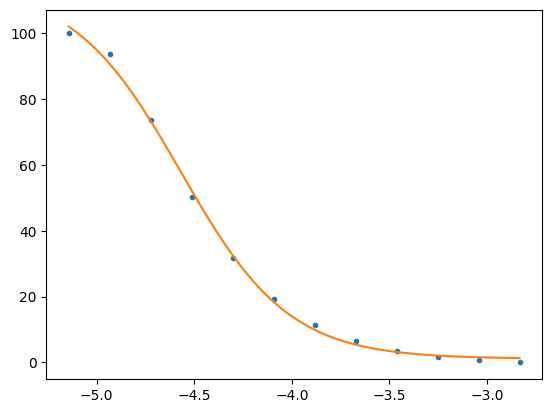

In [ ]:
temp = np.linspace(min(data['x']), max(data['x']), 50)
plt.plot(data['x'], data['y'], ".")
plt.plot(temp, f_curve_vec(temp, *theta), "-");
print(H)

# Hill slope estimation

## Example

In [ ]:
logKd = -0.005 # Dimerization
# Substrate binding
logK_S_DS = -13.853
logK_S_M = -6.015
logK_S_D = -9.312
# Inhibitor binding
logK_I_M = 0
logK_I_D = -17.669
logK_I_DI = -18.141
# Binding of substrate and inhibitor
logK_S_DI = -13.967

kcat_MS = 0
kcat_DS = 0
kcat_DSI = 0.45
kcat_DSS = 0.38

init_logMtot = np.log(1E-6) # Notice the unit is log scale
init_logStot = np.log(0.25E-3) # Notice the unit is log scale

params = [logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI, kcat_MS, kcat_DS, kcat_DSS, kcat_DSI]

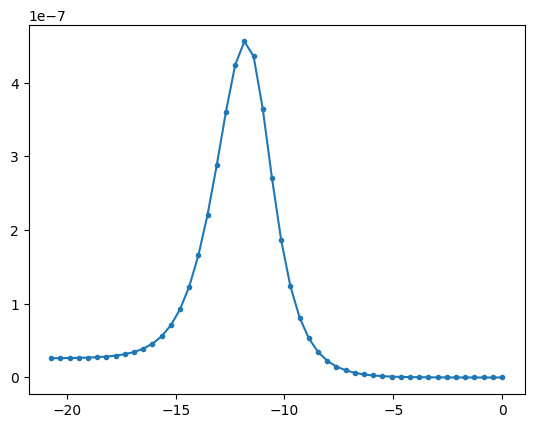

In [ ]:
logMtot = np.array([np.log(10E-6)]*50) 
logStot = np.array([np.log(0.25E-3)]*50) 
logItot = np.linspace(np.log(1E-9), np.log(1), 50)

R = ReactionRate(logMtot, logStot, logItot,
                 logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                 kcat_MS, kcat_DS, kcat_DSS, kcat_DSI)
plt.plot(logItot, R, ".-");

1.2531268899994579


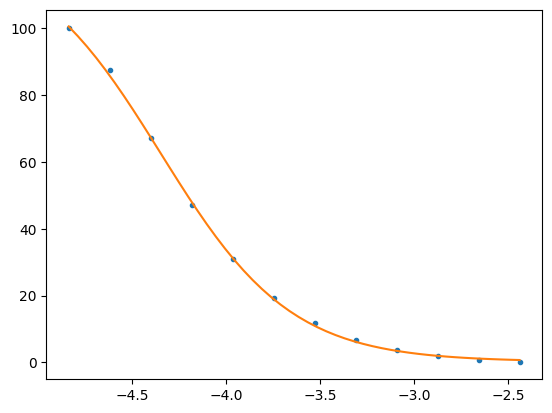

In [ ]:
[logMtot, logStot, logItot] = return_logItot(init_logMtot, init_logStot, params)
v_observed = ReactionRate(logMtot, logStot, logItot,
                          logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI,
                          kcat_MS, kcat_DS, kcat_DSS, kcat_DSI)
# Create data for CRC fitting
data = {}
data['x'] = np.log10(np.exp(logItot))
data['y'] = scaling_data(v_observed, min(v_observed), max(v_observed))
# CRC fitting
[theta, ASE, var] = parameter_estimation(data)
[R_b, R_t, x50, H] = theta
# Plotting
temp = np.linspace(min(data['x']), max(data['x']), 50)
plt.plot(data['x'], data['y'], ".")
plt.plot(temp, f_curve_vec(temp, *theta), "-");
print(H)

## 1000 LHS

In [ ]:
os.chdir("/content/drive/MyDrive/MoonShot/dimer/LHS")

# Read the CSV file
LHS_file = '1A_1kTest1.csv'
df = pd.read_csv(LHS_file, header=None, skiprows=[0])
column_names = ['logK_S_M', 'logK_I_M', 'logKd', 'logK_S_D', 'logK_S_DS', 
                'logK_I_D', 'logK_I_DI', 'logK_S_DI', 'kcat_DS', 'kcat_DSI',
                'kcat_DSS', 'kcat_MS']
df.columns = column_names 
hill_slopes = []

In [ ]:
init_logMtot = np.log(10E-6) # Notice the unit is log scale
init_logStot = np.log(0.25E-3) # Notice the unit is log scale
# init_logStot = np.log(0.25E-4) # Notice the unit is log scale
# init_logStot = np.log(10E-6) # Notice the unit is log scale
# init_logStot = np.log(25E-4) # Notice the unit is log scale
# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    logK_S_M = row[0]
    logK_I_M = row[1]
    logKd = row[2] 
    logK_S_D = row[3]
    logK_S_DS = row[4]
    logK_I_D = row[5] # Inhibitor binding to free dimer
    logK_I_DI = row[6]
    logK_S_DI = row[7] # Substrate binding to inhibitor-dimer complex
    kcat_DS = row[8] 
    kcat_DSI = row[9] 
    kcat_DSS = row[10]
    kcat_MS = row[11]

    params = [logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI, kcat_MS, kcat_DS, kcat_DSS, kcat_DSI]

    # Calculate the predicted reaction rate
    [logMtot, logStot, logItot] = return_logItot(init_logMtot, init_logStot, params)
    if len(np.unique(logItot))==1:
        [logMtot, logStot, logItot] = return_logItot(init_logMtot, init_logStot, params, n_points=200)
    
    v_observed = ReactionRate(logMtot, logStot, logItot, *params)

    # Create data for CRC fitting
    data = {}
    data['x'] = np.log10(np.exp(logItot))
    data['y'] = scaling_data(v_observed, min(v_observed), max(v_observed))
    # CRC fitting
    [theta, ASE, var] = parameter_estimation(data)
    [R_b, R_t, x50, H] = theta
    
    # Add the hill slope to the list of slopes
    hill_slopes.append(H)

    # # If Hill Slope is >= 2, print the parameters
    # if H >= 2:
    #     print(f"Row {index}")

# Print the list of hill slopes in ascending order
print(' '.join(map(str, sorted(hill_slopes))))

In [ ]:
max(hill_slopes)

4.729000897421763

In [ ]:
np.where(np.isclose(np.array(hill_slopes), 2, rtol=0.5))
# np.where(np.isclose(np.array(hill_slopes), 0.75, rtol=0.01))
# np.where(np.isclose(np.array(hill_slopes), 0.2, rtol=0.1))

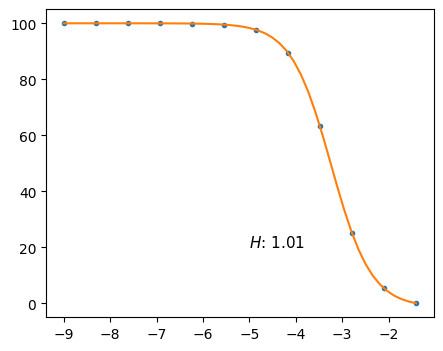

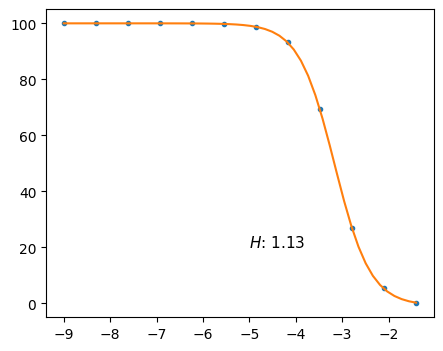

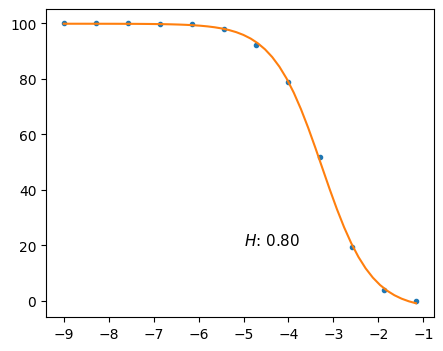

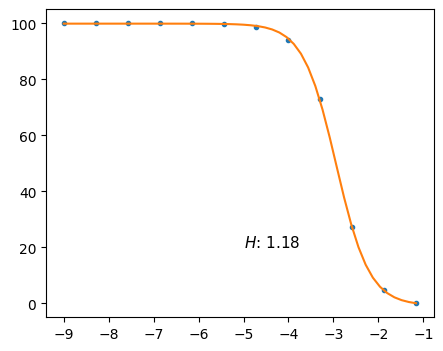

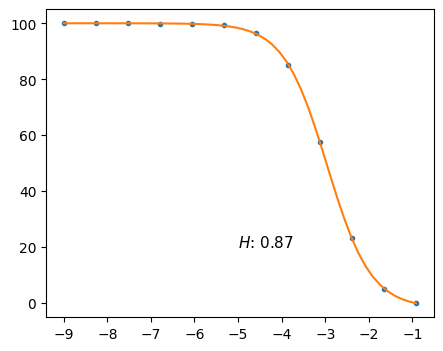

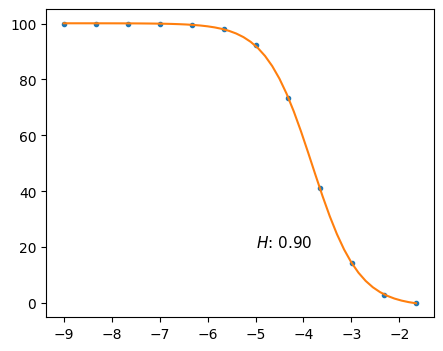

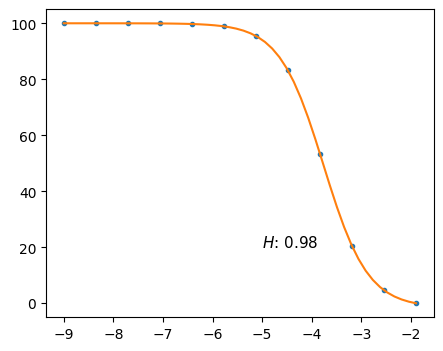

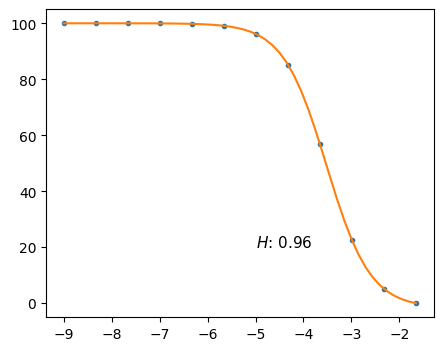

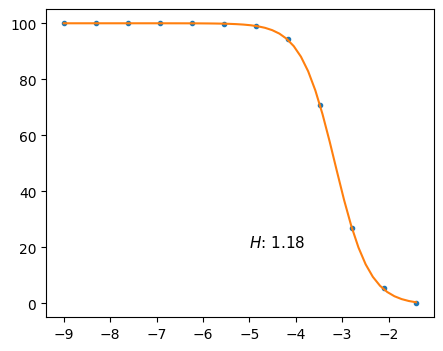

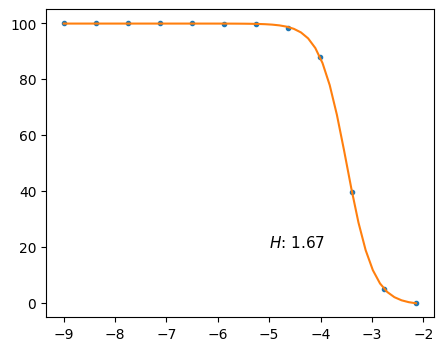

In [ ]:
for i in range(10):
    fig = plt.figure(figsize=(5, 4))
    row = df.iloc[i]
    logK_S_M = row[0]
    logK_I_M = row[1]
    logKd = row[2] 
    logK_S_D = row[3]
    logK_S_DS = row[4]
    logK_I_D = row[5] # Inhibitor binding to free dimer
    logK_I_DI = row[6]
    logK_S_DI = row[7] # Substrate binding to inhibitor-dimer complex
    kcat_DS = row[8] 
    kcat_DSI = row[9] 
    kcat_DSS = row[10]
    kcat_MS = row[11]
    init_logMtot = np.log(10E-6) # Notice the unit is log scale
    init_logStot = np.log(0.25E-3) # Notice the unit is log scale
    params = [logKd, logK_S_M, logK_S_D, logK_S_DS, logK_I_M, logK_I_D, logK_I_DI, logK_S_DI, kcat_MS, kcat_DS, kcat_DSS, kcat_DSI]

    # Calculate the predicted reaction rate
    [logMtot, logStot, logItot] = return_logItot(init_logMtot, init_logStot, params)
    if len(np.unique(logItot))==1:
        [logMtot, logStot, logItot] = return_logItot(init_logMtot, init_logStot, params, n_points=200)

    v_observed = ReactionRate(logMtot, logStot, logItot, *params)

    # Create data for CRC fitting
    data = {}
    data['x'] = np.log10(np.exp(logItot))
    data['y'] = scaling_data(v_observed, min(v_observed), max(v_observed))
    # CRC fitting
    [theta, ASE, var] = parameter_estimation(data)
    [R_b, R_t, x50, H] = theta
    # Plotting
    temp = np.linspace(min(data['x']), max(data['x']), 50)

    plt.plot(data['x'], data['y'], ".")
    plt.plot(temp, f_curve_vec(temp, *theta), "-")
    plt.text(-5, 20, r'$H$: ' + str('%3.2f' %theta[3]), fontsize=11, color='k');

In [ ]:
df['hill'] = hill_slopes

In [ ]:
os.chdir("/content/drive/MyDrive/MoonShot/dimer/LHS")
df.to_csv("1A_1k_Hill.csv", index=False) #set logStot = np.log(0.25E-3)

# Save HTML

In [1]:
!jupyter nbconvert --to html "/content/drive/My Drive/MoonShot/dimer/20230418_Finding_logItot.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/MoonShot/dimer/20230418_Finding_logItot.ipynb to html
[NbConvertApp] Writing 1021074 bytes to /content/drive/My Drive/MoonShot/dimer/20230418_Finding_logItot.html
